# Module: dpc

This module contains functions for performing differential phase contrast imaging (DPC).

In DPC, the sample potential is reconstructed from shifts in the diffraction space center of mass of the electron beam at each scan position.  The idea is that deflection of the center of mass, under certain assumptions, scales linearly with the gradient of the phase of the sample transmittance.  When this correspondence holds, it is thus possible to invert the differential equation and extract the phase itself.* The phase scales with the potential according the the electron interaction constant.  The primary assumption made is that the sample is well described as a pure phase object (i.e. the real part of the transmittance is 1).  The inversion is performed here in Fourier space, i.e. using the Fourier transform property that derivatives in real space are turned into multiplication in Fourier space.

For more detailed discussion of the relavant theory, see, e.g.:
- Ishizuka et al, Microscopy (2017) 397-405
- Close et al, Ultramicroscopy 159 (2015) 124-137
- Waddell and Chapman, Optik 54 (1979) No. 2, 83-96

This notebook demos:
* Getting the CBED center and radius
* Finding the centers of mass
* Determining any rotational offset between the real and diffraction space coordinates
* Recontructing the phase from the centers of mass

*Note: because in DPC a differential equation is being inverted - i.e. the fundamental theorem of calculus is being invoked - one might be tempted to call this "integrated differential phase contrast".  Strictly speaking, this term is redundant - performing an integration is simply how DPC works.  Anyone who tells you otherwise is selling something.


### Import packages, load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import h5py
from scipy.ndimage.filters import gaussian_filter

import py4DSTEM
from py4DSTEM.process.calibration import get_probe_size
from py4DSTEM.process.dpc import get_CoM_images, get_rotation_and_flip, get_phase_from_CoM
from py4DSTEM.process.dpc import get_wavenumber, get_interaction_constant

ImportError: cannot import name 'get_rotation_and_flip' from 'py4DSTEM.process.dpc' (/home/ben/Projects/py4DSTEM/py4DSTEM/py4DSTEM/process/dpc/__init__.py)

In [2]:
from py4DSTEM.process.dpc import get_rotation_and_flip_maxcontrast

In [4]:
get_rotation_and_flip_maxcontrast?

In [2]:
# Load data

fp = "/home/ben/Data/20190509_DPC_MoS2_binned_HamishBrown/MoS2_binned.h5"
f = h5py.File(fp,'r')
data = np.array(f['4D-STEM_data/datacube/datacube'])
f.close()

dc = py4DSTEM.file.datastructure.DataCube(data[:,:255,:,:])

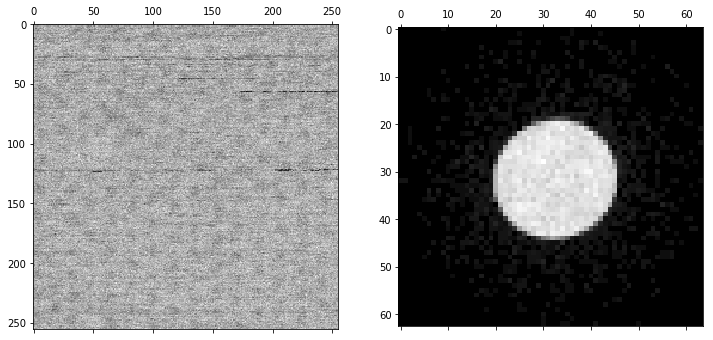

In [3]:
rx,ry = 30,30
power = .5

BF = np.average(dc.data,axis=(2,3))
DP = dc.data[rx,ry,:,:]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(BF)
ax2.matshow(DP**power)
plt.show()

### Get CBED center and radius

These are used for
1. Calibrating the diffraction plane pixel size
2. Masking the central disk

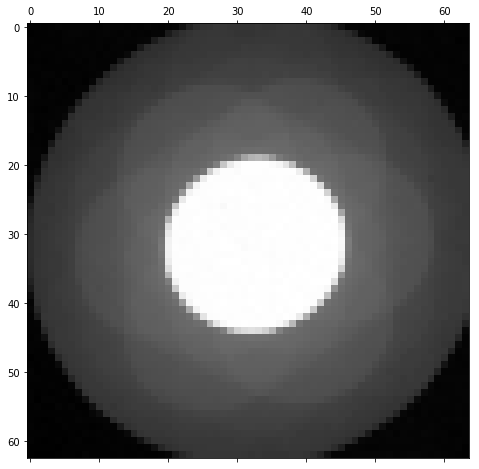

In [4]:
# Get PACBED

power = 0.1

PACBED = np.average(dc.data,axis=(0,1))

# Show
fig,ax = plt.subplots(figsize=(8,8,))
ax.matshow(PACBED**power)
plt.show()

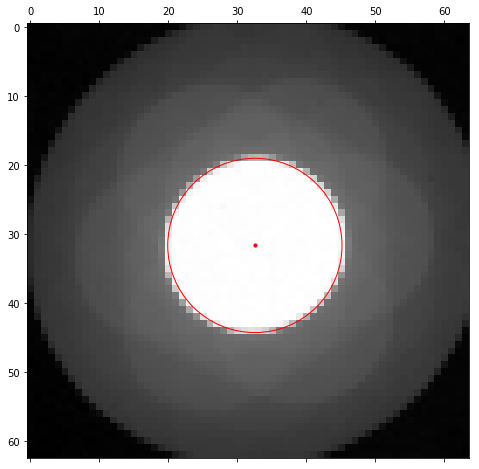

In [5]:
thresh_lower = 0.001
thresh_upper = 0.999
N = 100

r,x0,y0 = get_probe_size(PACBED, thresh_lower=thresh_lower, thresh_upper=thresh_upper, N=N)

# Show
fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(PACBED**power)
ax.scatter(y0,x0,color='r',s=10)
circle = Circle((y0,x0),r,fill=False,edgecolor='r',linewidth=1)
ax.add_patch(circle)
plt.show()

### Get centers of mass

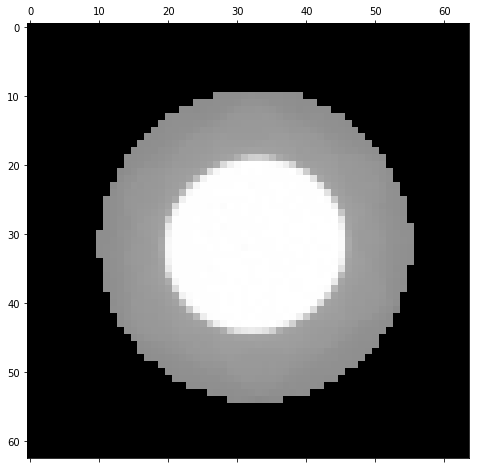

In [6]:
# Get mask

expand = 10

qy,qx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
qr = np.hypot(qx-x0,qy-y0)
mask = qr < r + expand

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow((mask*PACBED)**power)
plt.show()

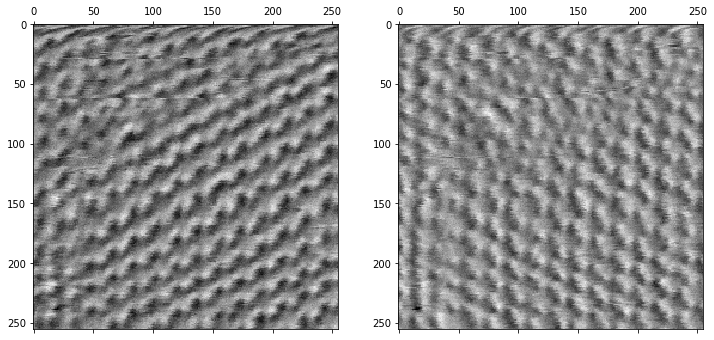

In [7]:
normalize = True

CoMx,CoMy = get_CoM_images(dc, mask=mask, normalize=normalize)

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(CoMx)
ax2.matshow(CoMy)
plt.show()

### Get rotation and flip

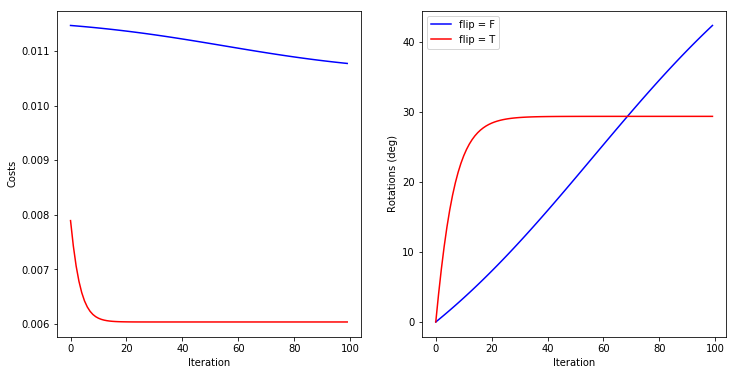

Rotational offset = 29.33 degrees
Flip is set to True


In [8]:
n_iter = 100
stepsize = 4
return_costs = True

theta, flip, thetas, costs, thetas_f, costs_f = get_rotation_and_flip(CoMx, CoMy, dc.Q_Nx, dc.Q_Ny, n_iter=n_iter,
                                                                      stepsize=stepsize, return_costs=return_costs)

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(np.arange(len(thetas)),costs,color='b')
ax1.plot(np.arange(len(thetas_f)),costs_f,color='r')
ax2.plot(np.arange(len(thetas)),np.degrees(thetas),color='b',label='flip = F')
ax2.plot(np.arange(len(thetas_f)),np.degrees(thetas_f),color='r',label='flip = T')
ax1.set_ylabel("Costs")
ax1.set_xlabel("Iteration")
ax2.set_ylabel("Rotations (deg)")
ax2.set_xlabel("Iteration")
ax2.legend()
plt.show()

print("Rotational offset = {:.4} degrees".format(np.degrees(theta)))
print("Flip is set to {}".format(flip))

### Reconstruction

In [9]:
paddingfactor = 2
regLowPass = 200
regHighPass = 0.3
stepSize = 0.5
n_iter = 20

phase, error = get_phase_from_CoM(CoMx, CoMy, theta=theta, flip=flip, regLowPass=regLowPass, regHighPass=regHighPass,
                                  paddingfactor=paddingfactor, stepsize=stepsize, n_iter=n_iter)

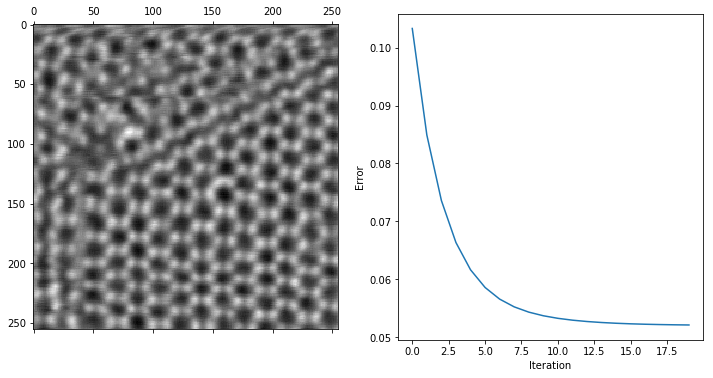

In [10]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(phase)
ax2.plot(np.arange(n_iter),error)
ax2.set_ylabel('Error')
ax2.set_xlabel('Iteration')
plt.show()